## Jane Street June 2022 (BlockParty 4)

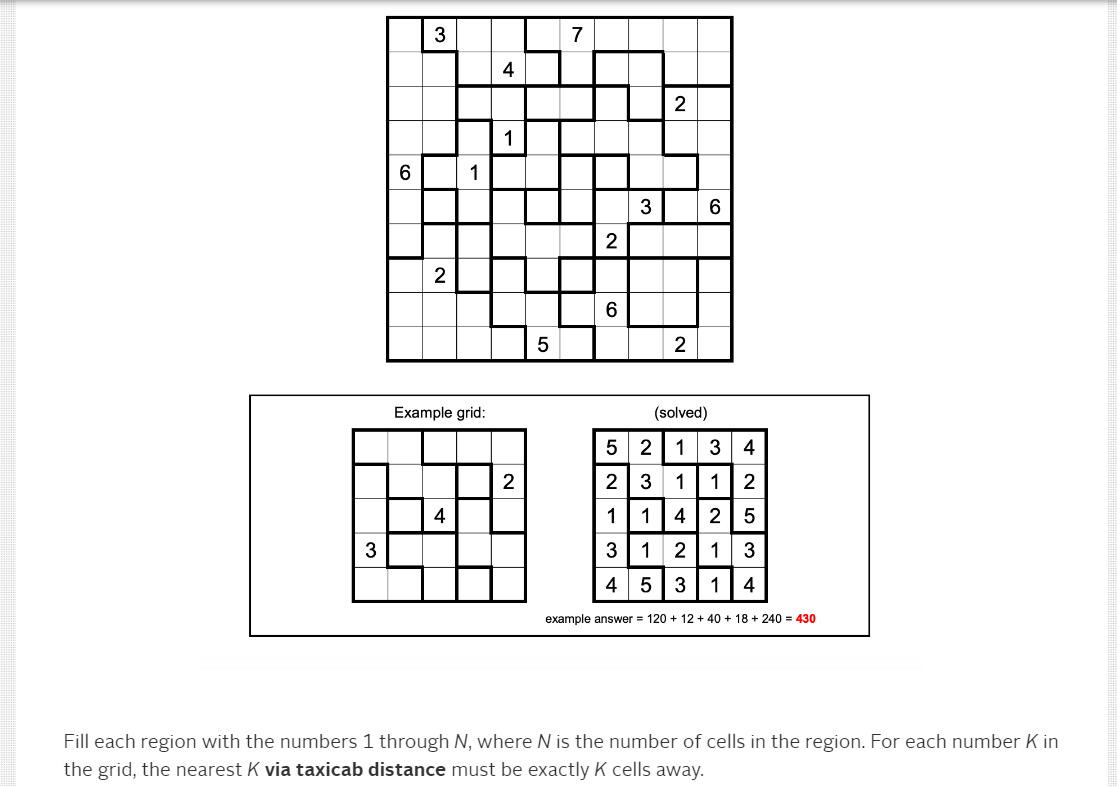

In [356]:
import copy
import numpy as np

In [2]:
#helper stuff
def ls_to_tuple(ls):
    new = []
    for i in range(0,len(ls),2):
        new.append((ls[i], ls[i+1]))
    return new

def taxi_distance(coord1, coord2):
        '''returns taxi-cab distance between two tuple coordinates'''
        return (abs(coord1[0]-coord2[0]) + abs(coord1[1]-coord2[1]))

In [359]:
class Board:
    n = 0
    starting_board = []
    board = []
    number_islands = 0
    islands = {}
    coords = {}
    
    def __init__(self, n, starting_board, islands):
        self.n = n
        self.starting_board = starting_board
        self.board = starting_board
        self.number_islands = len(islands)
        for i in range(self.number_islands):
            tups = islands[i]
            self.islands[i] = {"coords":tups, "max":len(tups), "completed":set(), "colour": f"\033[2;30;{41 + i%7}m "}
            for tup in tups:
                poss_val = []
                if self.starting_board[tup[0]][tup[1]]==0: poss_val = [i for i in range(1, len(tups)+1)]
                self.coords[tup] = {"val":self.starting_board[tup[0]][tup[1]], "poss_val":set(poss_val), "island":i, "max":len(tups), "colour": f"\033[2;30;{41 + i%7}m "}
        self.update_islands()
        return
    
    def reset(self):
        self.n = 0
        self.starting_board = []
        self.board = []
        self.number_islands = 0
        self.islands.clear()
        self.coords.clear()
        return
    
    def input_islands(self):
        '''
        input number of islands
        & islands in form x,y/x,y/...
        '''
        self.number_islands = int(input("Number of islands: "))
        for i in range(self.number_islands):
            single_row = list(map(int, input().split()))
            tups = ls_to_tuple(single_row)
            #print(tups)
            self.islands[i] = {"coords":tups, "max":len(tups), "colour": f"\033[2;30;{41 + i%7}m "}
            for tup in tups:
                self.coords[tup] = {"island":i, "max":len(tups), "colour": f"\033[2;30;{41 + i%7}m "}
        return
        
    def input_board(self):
        '''
        get dims of grid
        input starting entries in form number<space>number<space>...
        0 for no entry
        '''
        self.reset()
        self.n = int(input("Number of rows/columns: "))
        for i in range(self.n):
            single_row = list(map(int, input().split()))
            self.starting_board.append(single_row)
        self.input_islands()
        self.board = self.starting_board
        return
    
    def print_board(self):
        for i in range(self.n):
            for j in range(self.n):
                if j%self.n == 0:
                    print()
                print(self.coords[(i,j)]["colour"] + str(self.board[i][j]), end='')
        return
    
    def update_islands(self):
        '''
        goes through all islands and adds to each islands completed values
        '''
        for i in range(self.number_islands):
            for coord in self.islands[i]["coords"]:
                if self.coords[coord]['val'] != 0:
                    self.islands[i]["completed"].add(self.coords[coord]['val'])
                    
    def nearest_val(self, coord, value):
        '''
        return taxicab distance of coord to nearest 'value' entry
        returns zero if there is no distance
        '''
        distance = 2*self.n
        for i in range(self.n):
            for j in range(self.n):
                if self.board[i][j] == value:
                    coord_ = (i,j)
                    distance = min(distance, taxi_distance(coord, coord_))
        if distance == 2*self.n: return 0
        else: return distance
    
    def update_coord(self, coord, val):
        ''' update definitely correct entry'''
        island = self.coords[coord]['island']
        self.board[coord[0]][coord[1]] = val
        self.coords[coord]['val'] = val
        self.coords[coord]['poss_val'].clear()
        self.islands[island]['completed'].add(val)
    
    def update_possibles(self):
        '''do sweep of each coord
        update definite entries eliminate unvalid possible values
        based on taxi distance and island entries'''
        for i in range(self.n):
            for j in range(self.n):
                coord = (i, j)
                island = self.coords[coord]['island']
                #island values
                self.coords[coord]['poss_val'] = self.coords[coord]['poss_val'].difference(self.islands[island]['completed'])
                #taxi cab distances
                to_delete = set()
                for poss_val in self.coords[coord]['poss_val']:
                    if (self.nearest_val(coord, poss_val)!=0):
                        if (self.nearest_val(coord, poss_val) < poss_val):
                            to_delete.add(poss_val)
                self.coords[coord]['poss_val'] = self.coords[coord]['poss_val'].difference(to_delete)
                #update definite entries
                if len(self.coords[coord]['poss_val'])==1:
                    self.update_coord(coord,self.coords[coord]['poss_val'].pop())
#                     self.board[i][j] = self.coords[coord]['poss_val'].pop()
#                     self.coords[coord]['val'] = self.board[i][j]
#                     self.coords[coord]['poss_val'].clear()
                    
    def only_possible_island(self):
        '''search for definite values by comparing possibles by island'''
        for i in range(self.number_islands):
            for coord in self.islands[i]["coords"]:
                coord_poss = self.coords[coord]['poss_val']
                for coord_ in [x for x in self.islands[i]["coords"] if x != coord]:
                    coord_poss = coord_poss.difference(self.coords[coord_]['poss_val'])
                if len(coord_poss)==1:
                    self.update_coord(coord,coord_poss.pop())
        self.update_islands()
    
    def taxi_radius(self, coord, dist):
        '''returns list of coords in nxn grid that are dist away'''
        arr = []
        for i in range(self.n):
            for j in range(self.n):
                coord_ = (i,j)
                if taxi_distance(coord, coord_) == dist:
                    arr.append(coord_)
        return arr
    
    def taxi_interior(self, coord, dist):
        '''returns list of coords in nxn grid that are within dist away'''
        arr = []
        for i in range(self.n):
            for j in range(self.n):
                coord_ = (i,j)
                if taxi_distance(coord, coord_) < dist:
                    arr.append(coord_)
        return arr
    
    def check_K_nearest(self):
        '''perform sweep to check for K nearest'''
        for i in range(self.n):
            for j in range(self.n):
                coord = (i,j)
                if self.coords[coord]['val'] != 0:
                    val = self.coords[coord]['val']
                    count = 0
                    for coord_ in self.taxi_radius(coord, val):
                        if val in self.coords[coord]['poss_val']: count+=1
                    if count == 1:
                        for coord_ in self.taxi_radius(coord, val):
                            if val in self.coords[coord]['poss_val']:
                                self.update_coord(coord_, val)
                                self.update_islands()
    
    def island_availables(self, island, val):
        '''returns list of coords with no entry in that island, with poss entry val'''
        ls = []
        for coord in self.islands[island]['coords']:
            if (self.coords[coord]['val'] == 0) and (val in self.coords[coord]['poss_val']):
                ls.append(coord)
        return ls
    
    def island_remaining_vals(self, island):
        '''returns set of remaining values for island'''
        return set([i for i in range(1,self.islands[island]['max']+1)]).difference(self.islands[island]['completed'])
    
    def islands_needing(self, val):
        '''returns list of island indexes for those islands without val'''
        arr = []
        for island in range(self.number_islands):
            if val in self.island_remaining_vals(island):
                arr.append(island)
        return arr
    
    def crowding_island(self):
        '''remove possible value if that means another island can't have that value '''
        #print("coord", "island", "poss_vals")
        for i in range(self.n):
            for j in range(self.n):
                coord = (i,j)
                c_island = self.coords[coord]['island']
                poss_vals = list(self.coords[coord]['poss_val'])
                #print("coord:", "island:", "poss_vals:")
                #print(coord, c_island, poss_vals)
                for val in poss_vals:
                    #print("val: ", val)
                    interest_islands = self.islands_needing(val)
                    interest_islands.remove(c_island)
                    #print("islands of interest: ", interest_islands)
                    for island in interest_islands:
                        if (set(self.island_availables(island, val)) <= set(self.taxi_interior(coord, val))):
                            self.coords[coord]['poss_val'].discard(val)
                            #break
        
#check if whole island
    def only_available(self):
        '''check K radius update if only one available'''
        for i in range(self.n):
            for j in range(self.n):
                coord = (i,j)
                val = self.coords[coord]['val']
                if val != 0:
                    K_in_range = False
                    count = 0
                    K_radius = self.taxi_radius(coord, val)
                    for coord_ in K_radius:
                        if self.coords[coord_]['val'] == val:
                            K_in_range = True
                        if val in self.coords[coord_]['poss_val']:
                            count += 1
                    if (count == 1) and (K_in_range==False):
                        for coord_ in K_radius:
                            if val in self.coords[coord_]['poss_val']:
                                self.update_coord(coord_, val)
                                self.update_islands()
                                break
                                
                        


    #def find_possible(self):
    #    for i in range(self.n):
    #        for j in range(self.n):
    
    def number_of_boards(self):
        boards = 1
        for i in range(self.n):
            for j in range(self.n):
                coord = (i, j)
                if len(self.coords[coord]['poss_val'])!=0:
                    boards = boards*len(self.coords[coord]['poss_val'])
        return boards
    
    def board_to_matrix(self):
        mat = np.zeros((self.n, self.n))
        for i in range(self.n):
            for j in range(self.n):
                coord = (i,j)
                mat[i][j] = self.coords[coord]['val']
        return mat

In [360]:
def ls_to_tuple(ls):
    new = []
    for i in range(0,len(ls),2):
        new.append((ls[i], ls[i+1]))
    return new

In [361]:
#Example stuff
ex_board = [[0,0,0,0,0],
            [0,0,0,0,2],
            [0,0,4,0,0],
            [3,0,0,0,0],
            [0,0,0,0,0]]

ex_islands = [[(0,0), (0,1), (1,1), (1,2), (2,2)],
              [(0,2), (0,3), (0,4), (1,4), (2,4)],
              [(1,0), (2,0), (3,0), (4,0), (4,1)],
              [(2,1)],
              [(1,3)],
              [(3,1), (3,2), (4,2)],
              [(2,3), (3,3), (3,4), (4,4)],
             [(4,3)]]

example = Board(5, ex_board, ex_islands)

In [371]:
example.print_board()


 5 2 1 3 4
 2 3 1 1 2
 1 1 4 2 5
 3 0 0 1 3
 4 5 3 1 4

In [247]:
#example.coords

In [248]:
#example.coords[(3,2)]

In [249]:
#example.islands

In [372]:
#run a few times
example.update_possibles()
example.only_possible_island()
example.update_possibles()
example.crowding_island()
example.update_possibles()
example.only_available()
example.update_possibles()

In [364]:
example.only_possible_island()

In [365]:
example.crowding_island()

In [366]:
example.only_available()

In [284]:
#example_copy = copy.deepcopy(example)

In [13]:
#example_copy.coords[(3,2)]

In [12]:
#number of possible boards
#example.number_of_boards()

In [373]:
#puzzle

puz_board = [[0,3,0,0,0,7,0,0,0,0],
             [0,0,0,4,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,2,0],
             [0,0,0,1,0,0,0,0,0,0],
             [6,0,1,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,3,0,6],
             [0,0,0,0,0,0,2,0,0,0],
             [0,2,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,6,0,0,0],
             [0,0,0,0,5,0,0,0,2,0]]

puz_islands = [[(0,0), (1,0), (1,1), (2,0), (2,1), (3,0), (3,1), (4,0), (5,0), (6,0)],
              [(0,1), (0,2), (0,3), (1,2), (1,3), (1,4)],
              [(0,4), (0,5), (0,6), (0,7), (0,8), (0,9), (1,5), (1,8), (1,9)],
              [(1,6), (1,7), (2,7)],
              [(2,2), (2,3), (3,3)],
              [(2,4), (2,5)],
              [(2,6), (3,5), (3,6), (3,7), (4,7), (4,8)],
              [(2,8), (2,9), (3,8), (3,9), (4,9), (5,8), (5,9)],
              [(3,2), (4,1), (4,2), (5,2)],
              [(3,4), (4,3), (4,4)],
              [(4,5), (5,5)],
              [(4,6)],
              [(5,1)],
              [(5,3), (6,3), (6,4), (6,5), (7,4)],
              [(5,4)],
              [(5,6), (5,7), (6,6)],
              [(6,1), (7,0), (7,1), (8,0), (8,1), (8,2), (9,0), (9,1), (9,2), (9,3)],
              [(6,2), (7,2)],
              [(6,7), (6,8), (6,9)],
              [(7,3), (8,3), (8,4), (9,4), (9,5)],
              [(7,5)],
              [(7,6), (7,9), (8,5), (8,6), (8,9), (9,6), (9,7), (9,8), (9,9)],
              [(7,7), (7,8), (8,7), (8,8)]]

puzzle = Board(10, puz_board, puz_islands)

In [414]:
puzzle.update_possibles()
puzzle.only_possible_island()
#puzzle.check_K_nearest()
puzzle.crowding_island()
puzzle.update_possibles()
puzzle.only_available()
puzzle.update_possibles()

In [415]:
puzzle.print_board()


 4 3 6 5 3 7 4 9 6 5
 8 10 2 4 1 1 2 3 8 2
 9 2 3 2 1 2 5 1 2 4
 5 7 2 1 2 6 3 1 1 3
 6 3 1 1 3 2 1 4 2 7
 1 1 4 5 1 1 1 3 5 6
 3 1 2 3 2 4 2 1 2 3
 4 2 1 1 1 1 3 1 4 9
 5 8 3 4 2 1 6 2 3 8
 7 6 9 10 5 3 4 7 2 5

In [412]:
puzzle.update_coord((5,0), 1)

In [416]:
puzzle.board_to_matrix()

array([[ 4.,  3.,  6.,  5.,  3.,  7.,  4.,  9.,  6.,  5.],
       [ 8., 10.,  2.,  4.,  1.,  1.,  2.,  3.,  8.,  2.],
       [ 9.,  2.,  3.,  2.,  1.,  2.,  5.,  1.,  2.,  4.],
       [ 5.,  7.,  2.,  1.,  2.,  6.,  3.,  1.,  1.,  3.],
       [ 6.,  3.,  1.,  1.,  3.,  2.,  1.,  4.,  2.,  7.],
       [ 1.,  1.,  4.,  5.,  1.,  1.,  1.,  3.,  5.,  6.],
       [ 3.,  1.,  2.,  3.,  2.,  4.,  2.,  1.,  2.,  3.],
       [ 4.,  2.,  1.,  1.,  1.,  1.,  3.,  1.,  4.,  9.],
       [ 5.,  8.,  3.,  4.,  2.,  1.,  6.,  2.,  3.,  8.],
       [ 7.,  6.,  9., 10.,  5.,  3.,  4.,  7.,  2.,  5.]])

In [419]:
x = puzzle.board_to_matrix()
mult = np.multiply.reduce(x, axis=1)
mult

array([8.1648e+06, 6.1440e+04, 8.6400e+03, 7.5600e+03, 6.0480e+03,
       1.8000e+03, 1.7280e+03, 8.6400e+02, 2.7648e+05, 1.5876e+07])

In [420]:
Ans = np.sum(mult)
print('Puzzle answer: ', Ans)

Puzzle answer:  24405360.0


In [421]:
alt1 = np.array([[ 4.,  3.,  6.,  5.,  3.,  7.,  4.,  9.,  6.,  5.],
       [ 8., 10.,  2.,  4.,  1.,  1.,  2.,  3.,  8.,  2.],
       [ 9.,  2.,  3.,  2.,  1.,  2.,  5.,  1.,  2.,  4.],
       [ 5.,  7.,  2.,  1.,  2.,  6.,  3.,  1.,  1.,  3.],
       [ 6.,  3.,  1.,  1.,  3.,  1.,  1.,  4.,  2.,  7.],
       [ 1.,  1.,  4.,  5.,  1.,  2.,  1.,  3.,  5.,  6.],
       [ 3.,  1.,  2.,  3.,  2.,  4.,  2.,  1.,  2.,  3.],
       [ 4.,  2.,  1.,  1.,  1.,  1.,  3.,  1.,  4.,  9.],
       [ 5.,  8.,  3.,  4.,  2.,  1.,  6.,  2.,  3.,  8.],
       [ 7.,  6.,  9., 10.,  5.,  3.,  4.,  7.,  2.,  5.]])
mult = np.multiply.reduce(alt1, axis=1)
Ans = np.sum(mult)
print('Puzzle answer: ', Ans)

Puzzle answer:  24404136.0


In [422]:
alt2 = np.array([[ 4.,  3.,  6.,  5.,  3.,  7.,  4.,  9.,  6.,  5.],
       [ 8., 10.,  2.,  4.,  1.,  1.,  2.,  3.,  8.,  2.],
       [ 9.,  2.,  3.,  2.,  1.,  2.,  5.,  1.,  2.,  4.],
       [ 5.,  7.,  2.,  1.,  2.,  6.,  3.,  1.,  1.,  3.],
       [ 6.,  3.,  1.,  1.,  3.,  1.,  1.,  4.,  2.,  7.],
       [ 1.,  1.,  4.,  5.,  1.,  2.,  1.,  3.,  5.,  6.],
       [ 3.,  1.,  2.,  3.,  2.,  4.,  2.,  1.,  2.,  3.],
       [ 4.,  2.,  1.,  2.,  1.,  1.,  3.,  1.,  4.,  9.],
       [ 5.,  8.,  3.,  4.,  1.,  1.,  6.,  2.,  3.,  8.],
       [ 7.,  6.,  9., 10.,  5.,  3.,  4.,  7.,  2.,  5.]])
mult = np.multiply.reduce(alt2, axis=1)
Ans = np.sum(mult)
print('Puzzle answer: ', Ans)

Puzzle answer:  24266760.0


In [423]:
alt4 = np.array([[ 4.,  3.,  6.,  5.,  3.,  7.,  4.,  9.,  6.,  5.],
       [ 8., 10.,  2.,  4.,  1.,  1.,  2.,  3.,  8.,  2.],
       [ 9.,  2.,  3.,  2.,  1.,  2.,  5.,  1.,  2.,  4.],
       [ 5.,  7.,  2.,  1.,  2.,  6.,  3.,  1.,  1.,  3.],
       [ 6.,  3.,  1.,  1.,  3.,  2.,  1.,  4.,  2.,  7.],
       [ 1.,  1.,  4.,  5.,  1.,  1.,  1.,  3.,  5.,  6.],
       [ 3.,  1.,  2.,  3.,  2.,  4.,  2.,  1.,  2.,  3.],
       [ 4.,  2.,  1.,  2.,  1.,  1.,  3.,  1.,  4.,  9.],
       [ 5.,  8.,  3.,  4.,  1.,  1.,  6.,  2.,  3.,  8.],
       [ 7.,  6.,  9., 10.,  5.,  3.,  4.,  7.,  2.,  5.]])
mult = np.multiply.reduce(alt4, axis=1)
Ans = np.sum(mult)
print('Puzzle answer: ', Ans)

Puzzle answer:  24267984.0
